# Actor Critic with Prioritized Experience Replay

Experience replay database implemented using a sum tree. The priority of a transition is based on the TD-error, which tells how good than expected (estemiated by critic network) is this transition.

![title](res/ACERP.png)

In [1]:
import gym
from gym import envs
from gym import wrappers

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from itertools import count

import argparse
import logging
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from Network.deepnetsoftmax import Netsoftmax
from Network.deepnet import Net
from Memory.MemoryBuffer import ReplayMemory

from Agents.Actor import Actor
from Agents.Critic import Critic

from collections import namedtuple

Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state'))

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

### Sum Tree Memory 

In [2]:
class SumTree(object):
    
    data_pointer = 0
    length = 0
    
    def __init__ (self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity -1)  # parent nodes: capacity-1, leaves: capacity
        self.data = np.zeros(capacity, dtype=object)  # data is transition
         
            
    def add(self, p, data): 
    # add node
    # args: priority p and transition data       
        tree_idx = self.data_pointer + self.capacity -1
        self.data[self.data_pointer] = data    # update data frame 
        self.update(tree_idx, p)
        
        self.data_pointer += 1
        self.length += self.length
        if self.data_pointer >= self.capacity:     # replace when memory full
            self.data_pointer = 0
        
        
    def update(self, tree_idx, p):
    # update a node with new key (td-error)
    # used by add operation
        change = p - self.tree[tree_idx]
        self.tree[tree_idx] = p
        # percolate 
        while tree_idx != 0:
            tree_idx = (tree_idx - 1)//2
            self.tree[tree_idx] += change 
        
        
    def sample(self, v):
    # prioritized sample from memoory
        parent_idx = 0
        while True: 
            cl_idx = 2 * parent_idx + 1
            cr_idx = parent_idx + 1
            
            if cl_idx >= len(self.tree):  # reach bottom, end search 
                leaf_idx = parent_idx
                break
            else:     # downward search, always search for a higher priority node
                if v <= self.tree[cl_idx]:
                    parent_idx = cl_idx 
                else: 
                    v -= self.tree[cl_idx]
                    parent_idx = cr_idx 
        
        data_idx = leaf_idx - self.capacity + 1
        return leaf_idx, self.tree[leaf_idx], self.data[data_idx]
                 
    @property
    def total_p(self):
    # get sum
        return self.tree[0]  # root 
        

In [3]:
class SumTreeMemoryBuffer(object):
    """Prioritized experience replay, 
         implemented by sum tree"""
    
    epsilon = 0.01  # small amount to avoid zero priority
    alpha = 0.6  # [0~1] convert the importance of TD error to priority
    beta = 0.4  # importance-sampling, from initial value increasing to 1
    beta_increment_per_sampling = 0.001
    abs_err_upper = 1.  # clipped abs error 
    
    def __init__(self, capacity):
        self.tree = SumTree(capacity)
    
    def save(self, *args):
    # Store transition to memory
        max_p = np.max(self.tree.tree[-self.tree.capacity:])
        if max_p == 0:
            max_p = self.abs_err_upper
        self.tree.add(max_p, Transition(*args))   
        
    def sample(self, n):
        b_idx = np.empty((n,), dtype=np.int32) 
        b_memory = np.empty((n, self.tree.data[0].size))
        ISWeight = np.empty((n, 1))  
        pri_seg = self.tree.total_p() / n
        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])  # max = 1
        
        min_prob = np.min(self.tree.tree[-self.tree.capacity:]) / self.tree.total_p     # for later calculate ISweight
        
        for i in range(n):
            a, b = pri_seg * i, pri_seg * (i+1)
            v = np.random.uniform(a, b)
            idx, p, data = self.tree.sample(v)
            prob = p / self.tree.total_p
            ISWeights[i, 0] = np.power(prob/min_prob, -self.beta)
            b_idx[i], b_memory[i, :] = idx, data
            
        return b_memory
    
    
    def batch_update(self, tree_idx, abs_errors):
        
        abs_errors += self.epsilon  # convert to abs and avoid 0
        clipped_errors = np.minimum(abs_errors, self.abs_err_upper)
        ps = np.power(clipped_errors, self.alpha)
        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p) 
                       
    def __len__(self):
        return self.tree.length
    
        

In [6]:
def plot(x,d,la,lc):
    fig = plt.figure(figsize=(12,12))
    plt.clf()
    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2)
    ax3 = fig.add_subplot(2,2,3)
    ax4 = fig.add_subplot(2,2,4)
    
    ax1.plot(x)
    ax2.plot(d)
    ax3.plot(la)
    ax4.plot(lc)
    ax1.set_title('REWARD - Training LunarLander-v2')
    ax1.set_ylabel('Reward per Episode')
    ax2.set_ylabel('Durations per Episode')
    ax3.set_ylabel('Actor Loss per Episode')
    ax4.set_ylabel('Critic Loss(TDerror) per Episode')
    
    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())
        

In [ ]:

def start(GAME_NAME, BATCH_SIZE, MEMORY_CAPACITY):
    env = gym.make(GAME_NAME)
    actor = Actor(env.observation_space, env.action_space)
    critic = Critic(env.observation_space, env.action_space)
    reward_per_epi=[]
    durations_per_epi=[]
    l_A=[]
    l_C=[]
    
    MAX_EPISODE = 150
    RENDER = False
    MAX_EP_STEPS= 1000
    DISPLAY_REWARD_THRESHOLD=200
    BATCH_SIZE=BATCH_SIZE   
    MEMORY_CAPACITY=MEMORY_CAPACITY  
    replay_memory = SumTreeMemoryBuffer(MEMORY_CAPACITY)
    
    print "begin.\n\n"
    for i_episode in range(MAX_EPISODE):
        s = env.reset()
        track_r = []     
        critic._v_=[]
        actor._loss_=[]
        for t in count():
            if RENDER: env.render()

            a = actor.choose_action(s)

            s_, r, done, info = env.step(a)

            if done: r = -20    # 回合结束的惩罚/ Penalty if die

            track_r.append(r)
            
            # ACER: Critic Actor with Experience Replay
            if not done:
                replay_memory.save(s, a, r, s_)   # Save non-final transition into memeory
            
            if len(replay_memory) >= BATCH_SIZE:
                transitions = replay_memory.sample(BATCH_SIZE)   # Sample from memory for training
                batch = Transition(*zip(*transitions))
                
                s_b = np.asarray(batch.state)       
                s_b_n = np.asarray(batch.next_state)  
                a_b = np.asarray(batch.action).reshape(BATCH_SIZE, 1)
                r_b = np.asarray(batch.reward).reshape(BATCH_SIZE, 1) 
                
                td_error = critic.learn(s_b, r_b, s_b_n)    # Critic Learn  
                actor.learn(s_b, a_b, td_error)       # Actor Learn     

            s = s_
            
            print "... in episode (%d) step (%d)" % (i_episode+1,t)
            if is_ipython:
                display.clear_output(wait=True)
                display.display(plt.gcf())
            #env.render()

            if done or t >= MAX_EP_STEPS:
                ep_rs_sum = sum(track_r)/float(t)
                if 'running_reward' not in globals():
                    running_reward = ep_rs_sum
                else:
                    running_reward = running_reward * 0.95 + ep_rs_sum * 0.05
                if running_reward > DISPLAY_REWARD_THRESHOLD: RENDER = True  # rendering
                reward_per_epi.append(running_reward)
                durations_per_epi.append(t)
                l_A.append(np.mean(actor._loss_))
                l_C.append(np.mean(critic._loss_))
                print("episode:", i_episode, "  reward:", running_reward)
                plot(reward_per_epi, durations_per_epi, l_A, l_C)

                break
            
    return reward_per_epi, durations_per_epi, l_A, l_C       

    

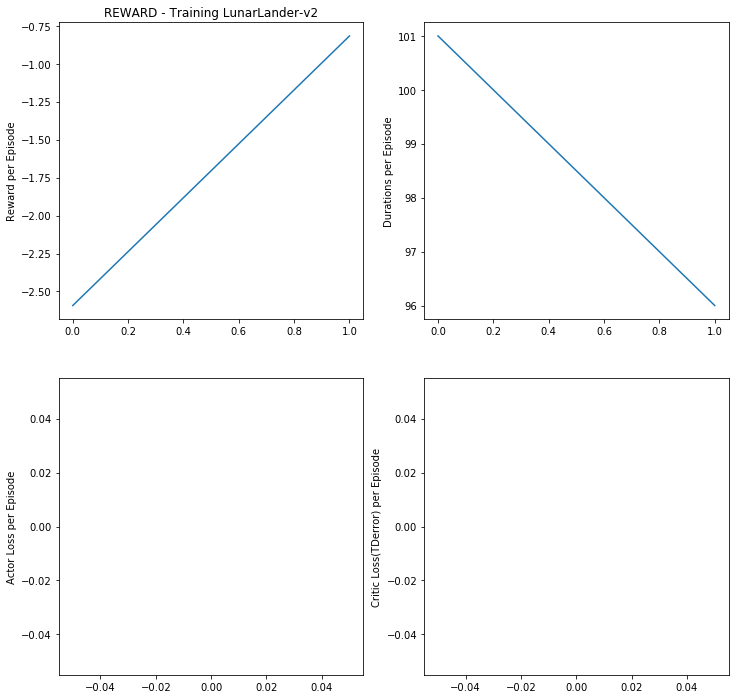

(pick)Actor: act prob
Variable containing:
 0.2345  0.2433  0.2562  0.2660
[torch.FloatTensor of size 1x4]

... in episode (3) step (109)


In [ ]:
r3, d3, l_A3, l_C3 = start('LunarLander-v2', BATCH_SIZE=1, MEMORY_CAPACITY=5)
plot(r3, d3, l_A3, l_C3)
print "episode, r > 0: %.01f%s" % (float(r_percent(r3, 0)*100), "%")
print "episode, r > -1: %.01f%s" % (float(r_percent (r3, -1)*100) , "%")
print "episode, r > -2: %.01f%s" % (float(r_percent (r3, -2)*100) , "%")
print "Highest score: %.02f" % max(r3)
print "Highest total score: %.01f" % max([x*y for x, y in zip(r3, d3)])